# Exemplary use of `system_from_excel.py`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Dict, List, Tuple
from pvmismatch.pvmismatch_lib import pvcell, pvmodule, pvstring, pvsystem
from mismatch_study.sys_mismatch_calculator import loss_calculator
from mismatch_study.sys_mismatch_calculator import mpp_from_curve

In [2]:
# =========================
# Constants / Configuration
# =========================
num_inverters = 43
num_channels_per_inv = 14
num_strs_per_channel = 2
num_strs_per_inv = 28
num_modules_per_str = 30

# Healthy cell characteristics (STC baseline)
HEALTHY_PARAMS = dict(
    Rs=0.00641575,
    Rsh=285.79,
    Isc0_T0=8.69,
    alpha_Isc=0.00060,
    Isat1_T0=1.79556E-10,
    Isat2_T0=1.2696E-5,
)

# Degradation multipliers for levels 1-6
# Matches the factors used for 10%, 20%, 30% degradation etc.
DEG_LEVELS = {
    1: (1.965, 1.965),  # Rs*1.965 ; Rsh/1.965
    2: (2.980, 2.980),  # Rs*2.980 ; Rsh/2.980
    3: (4.070, 4.070),  # Rs*4.070 ; Rsh/4.070
    4: (5.300, 5.300),  # Rs*5.300 ; Rsh/5.300
    5: (6.815, 6.815),  # Rs*6.815 ; Rsh/6.815
    6: (8.970, 8.970),  # Rs*8.970 ; Rsh/8.970
}

In [3]:
# ===============
# HELPER BUILDERS
# ===============

def _get_inv_code(inverter: int) -> str:
    """Return inverter code as used in spreadsheet, e.g., 1 -> 'I01', 12 -> 'I12'."""
    return f"I0{inverter}" if inverter < 10 else f"I{inverter}"

def _parse_str_index(string_name: str) -> int:
    """
    Extract 1-based string index from names like '..._STR06'.
    Raises ValueError if not found.
    """
    m = re.search(r"STR(\d+)", str(string_name))
    if not m:
        raise ValueError(f"Could not parse string index from StringName='{string_name}'")
    return int(m.group(1))

def _make_cell(rs: float, rsh: float) -> pvcell.PVcell:
    """Create a PVcell with healthy parameters except overridden Rs/Rsh."""
    return pvcell.PVcell(Rs=rs, Rsh=rsh,
                         Isc0_T0=HEALTHY_PARAMS["Isc0_T0"], alpha_Isc=HEALTHY_PARAMS["alpha_Isc"],
                         Isat1_T0=HEALTHY_PARAMS["Isat1_T0"], Isat2_T0=HEALTHY_PARAMS["Isat2_T0"])

def _make_module_from_cell(cell: pvcell.PVcell) -> pvmodule.PVmodule:
    # 72-cell module layout
    return pvmodule.PVmodule(cell_pos=pvmodule.STD72, pvcells=[cell] * 72)

def _get_module_prototypes() -> Dict[str, pvmodule.PVmodule]:
    """
    Build PVmodule prototypes for Healthy and each degraded level L1..L6.
    Returns a dict: {"H": PVmodule, "L1": PVmodule, ..., "L6": PVmodule}.
    """
    # Healthy module
    healthy_cell = _make_cell(HEALTHY_PARAMS["Rs"], HEALTHY_PARAMS["Rsh"])
    prototypes = {"H": _make_module_from_cell(healthy_cell)}

    # Degraded modules by level
    for lvl, (rs_factor, rsh_factor) in DEG_LEVELS.items():
        cell = _make_cell(HEALTHY_PARAMS["Rs"] * rs_factor, HEALTHY_PARAMS["Rsh"] / rsh_factor)
        prototypes[f"L{lvl}"] = _make_module_from_cell(cell)
    return prototypes

def _instantiate_modules(proto: pvmodule.PVmodule, count: int) -> List[pvmodule.PVmodule]:
    """
    Create 'count' fresh PVmodule instances with the same cell parameters as 'proto'.
    """
    # Extract the first cell to replicate parameters
    c = proto.pvcells[0]
    cell_copy = pvcell.PVcell(Rs=float(c.Rs), Rsh=float(c.Rsh),
                              Isc0_T0=float(c.Isc0_T0), alpha_Isc=float(c.alpha_Isc),
                              Isat1_T0=float(c.Isat1_T0), Isat2_T0=float(c.Isat2_T0))
    return [_make_module_from_cell(cell_copy) for _ in range(count)]

def _compose_string_modules(counts: Dict[str, int], protos: Dict[str, pvmodule.PVmodule]) -> List[pvmodule.PVmodule]:
    """
    Compose a list of 30 PVmodule instances for one string using counts:
    counts = {"H": L0_healthy, "L1": L1, "L2": L2, "L3": L3}
    """
    modules: List[pvmodule.PVmodule] = []
    for key in ("H", "L1", "L2", "L3"):
        if counts.get(key, 0) > 0 and key in protos:
            modules.extend(_instantiate_modules(protos[key], counts[key]))
    # Ensure total = 30; if fewer, pad with healthy; if more, trim (safety)
    if len(modules) < num_modules_per_str:
        short = num_modules_per_str - len(modules)
        modules.extend(_instantiate_modules(protos["H"], short))
    elif len(modules) > num_modules_per_str:
        modules = modules[:num_modules_per_str]
    return modules

# ===============
# EXCEL UTILITIES
# ===============

def _read_inverter_rows(path: str, sheet: str, inv_code: str) -> pd.DataFrame:
    """
    Read Excel and return rows for a single inverter code.
    Expected columns (at least): Inverter, StringName, L0_healthy, L1..L6, TotalMods.
    Missing L-levels default to 0; missing TotalMods defaults to num_modules_per_str.
    """
    df = pd.read_excel(
        path,
        sheet_name=sheet,
        usecols="A:G",
        skiprows=1,
        engine="openpyxl",
    )
    return df.loc[df["Inverter"].astype(str) == inv_code].copy()

def _build_inverter_strings(df: pd.DataFrame, protos: Dict[str, pvmodule.PVmodule]) -> Tuple[List[pvstring.PVstring], Dict[int, Dict[str, int]]]:
    """
    Build 28 PVstrings for an inverter, mapping any missing string to healthy.
    Returns:
      - list of PVstring objects
      - metadata dict per string index with counts used
    """
    # Initialize all 28 strings as healthy
    base_counts = {"H": num_modules_per_str}
    base_counts.update({f"L{i}": 0 for i in range(1, 7)})

    per_str_counts: Dict[int, Dict[str, int]] = {i: dict(base_counts) for i in range(1, num_strs_per_inv + 1)}

    # Apply degradation where mentioned
    for _, row in df.iterrows():
        try:
            sidx = _parse_str_index(row["StringName"])
        except ValueError:
            continue
        if 1 <= sidx <= num_strs_per_inv:
            healthy = int(row.get("L0_healthy", 0))
            # Read up to 6 levels if present; default to 0
            levels = {f"L{i}": int(row.get(f"L{i}", 0)) for i in range(1, 7)}
            total = int(row.get("TotalMods", num_modules_per_str))

            # Clamp counts to 'total' safely
            remaining = total
            h = min(healthy, remaining)
            remaining -= h
            used = {"H": h}
            for i in range(1, 7):
                key = f"L{i}"
                k = min(levels[key], remaining)
                used[key] = k
                remaining -= k

            per_str_counts[sidx] = used

    # Build strings
    pvstrings: List[pvstring.PVstring] = []
    for sidx in range(1, num_strs_per_inv+1):
        counts = per_str_counts[sidx]
        mods = _compose_string_modules(counts, protos)
        pvstrings.append(pvstring.PVstring(pvmods=mods))
    return pvstrings, per_str_counts

# =================
# FACTORY FUNCTIONS
# =================

def create_system_from_excel(path="string_summary_edited.xlsx", sheet="Sheet2", inverter=1) \
        -> Tuple[pvsystem.PVsystem, Dict[int, Dict[str, int]]]:
    """Creates a PVsystem for a single inverter (28 strings) from the Excel file.

    Returns:
      (system, metadata) where metadata per string index has counts for {"H","L1","L2","L3"}.
    """
    inv_code = _get_inv_code(inverter)
    df = _read_inverter_rows(path, sheet, inv_code)
    protos = _get_module_prototypes()
    pvstrings, per_str_counts = _build_inverter_strings(df, protos)
    return pvsystem.PVsystem(pvstrs=pvstrings), per_str_counts

def create_all_inverters(path="string_summary_edited.xlsx", sheet="Sheet2") -> Dict[int, pvsystem.PVsystem]:
    """Build PVsystem for all inverters present (1..43). Missing entries default to healthy."""
    systems: Dict[int, pvsystem.PVsystem] = {}
    protos = _get_module_prototypes()
    # Read once to avoid repeated IO
    file = pd.read_excel(path, sheet_name=sheet, usecols="A:G", skiprows=1, engine="openpyxl")
    for inv_num in range(1, num_inverters+1):
        inv = _get_inv_code(inv_num)
        df = file.loc[file["Inverter"].astype(str) == inv].copy()
        pvstrings, _ = _build_inverter_strings(df, protos)
        systems[inv_num] = pvsystem.PVsystem(pvstrs=pvstrings)
    return systems

def create_combined_system(inverters: List[int], path="string_summary_edited.xlsx", sheet="Sheet2") -> pvsystem.PVsystem:
    """Create a single PVsystem by concatenating strings from the selected inverters."""
    file = pd.read_excel(path, sheet_name=sheet, usecols="A:G", skiprows=1, engine="openpyxl")
    protos = _get_module_prototypes()
    all_strings: List[pvstring.PVstring] = []
    for inv_num in inverters:
        inv = _get_inv_code(inv_num)
        df = file.loc[file["Inverter"].astype(str) == inv].copy()
        pvstrings, _ = _build_inverter_strings(df, protos)
        all_strings.extend(pvstrings)
    return pvsystem.PVsystem(pvstrs=all_strings)

# ==================
# PLOTTING FUNCTIONS
# ==================

def plot_system_iv_pv(sys: pvsystem.PVsystem, title: str = "System", save_path: str | None = None):
    """Quick IV/PV plot for a PVsystem with MPP, Isc, Voc markers."""
    Isys, Vsys, Psys = sys.Isys, sys.Vsys, sys.Psys

    # Compute system MPP (uses the same helper used elsewhere)
    Pmp, Imp, Vmp = mpp_from_curve(Isys, Vsys, Psys)

    fig, (ax_iv, ax_pv) = plt.subplots(1, 2, figsize=(11, 5))

    # IV
    ax_iv.plot(Vsys, Isys, label=title, color="tab:blue", linewidth=1.8)
    ax_iv.scatter([Vmp], [Imp], color="tab:purple", s=30, zorder=3, label="MPP")
    ax_iv.annotate(f"MPP\nI={Imp:.2f} A\nV={Vmp:.1f} V", xy=(Vmp, Imp),
                   xytext=(10, 10), textcoords="offset points",
                   fontsize=8, bbox=dict(boxstyle="round", fc="white", ec="tab:purple", alpha=0.8))

    ax_iv.set_title(f"I–V: {title}")
    ax_iv.set_xlabel("Voltage [V]")
    ax_iv.set_ylabel("Current [A]")
    ax_iv.set_xlim(0, np.max(Vsys) * 1.05)
    ax_iv.set_ylim(0, np.max(Isys) * 1.05)
    ax_iv.grid(True, linestyle="--", alpha=0.4)
    ax_iv.legend(loc="best")

    # PV
    ax_pv.plot(Vsys, Psys, label=title, color="tab:red", linewidth=1.8)
    ax_pv.scatter([Vmp], [Pmp], color="tab:purple", s=30, zorder=3, label="MPP")
    ax_pv.annotate(f"Pmp={Pmp:.0f} W\nVmp={Vmp:.1f} V", xy=(Vmp, Pmp),
                   xytext=(10, -35), textcoords="offset points",
                   fontsize=8, bbox=dict(boxstyle="round", fc="white", ec="tab:purple", alpha=0.8))

    ax_pv.set_title(f"P–V: {title}")
    ax_pv.set_xlabel("Voltage [V]")
    ax_pv.set_ylabel("Power [W]")
    ax_pv.set_xlim(0, np.max(Vsys) * 1.05)
    ax_pv.set_ylim(0, np.max(Psys) * 1.05)
    ax_pv.grid(True, linestyle="--", alpha=0.4)
    ax_pv.legend(loc="best")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def plot_inverters(inverters: List[int], path="string_summary_edited.xlsx", sheet="Sheet2"):
    """Plot IV/PV for given inverter indices, each on its own figure."""
    for inv in inverters:
        sys, _ = create_system_from_excel(path=path, sheet=sheet, inverter=inv)
        plot_system_iv_pv(sys, title=f"Inverter {inv}")

# =================
# HEALTHY BASELINES
# =================

def create_healthy_inverter(inverter: int = 1) -> pvsystem.PVsystem:
    """
    Create a fully-healthy PVsystem for a single inverter (28 strings x 30 modules).
    Matches the electrical parameters used elsewhere in this module.
    """
    protos = _get_module_prototypes()
    # Build one healthy string
    mods_healthy = _instantiate_modules(protos["H"], num_modules_per_str)
    str_healthy = pvstring.PVstring(pvmods=mods_healthy)
    # Replicate to num_strs_per_inv
    pvstrings = []
    for _ in range(num_strs_per_inv):
        # fresh instances for each string to avoid shared state
        mods = _instantiate_modules(protos["H"], num_modules_per_str)
        pvstrings.append(pvstring.PVstring(pvmods=mods))
    return pvsystem.PVsystem(pvstrs=pvstrings)

def create_healthy_combined(inverters: List[int]) -> pvsystem.PVsystem:
    """
    Create one fully-healthy PVsystem by concatenating healthy strings
    for the selected inverter indices.
    """
    protos = _get_module_prototypes()
    all_strings: List[pvstring.PVstring] = []
    for _ in inverters:
        for _s in range(num_strs_per_inv):
            mods = _instantiate_modules(protos["H"], num_modules_per_str)
            all_strings.append(pvstring.PVstring(pvmods=mods))
    return pvsystem.PVsystem(pvstrs=all_strings)

## Single Inverter System and Plot

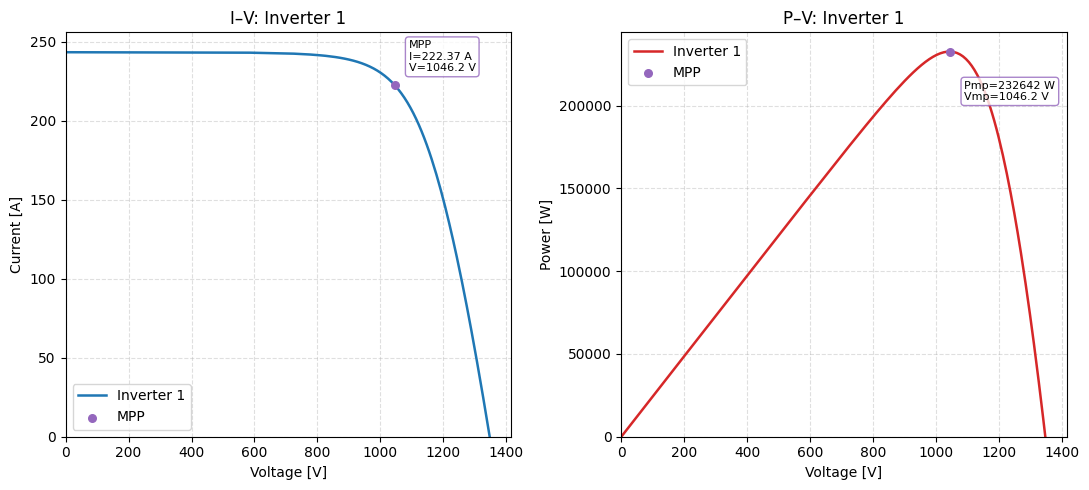


=== Mismatch Report for Inverter 1 ===
module_MPPs_sum_degraded: 232956.1979202479
module_MPPs_sum_healthy: 235956.7732779795
string_MPPs_sum_degraded: 232861.91792783947
string_MPPs_sum_healthy: 235956.77344405037
system_MPP_degraded: 232642.33640636998
system_MPP_healthy: 235957.29920618678
total_module_loss: 3000.5753577315772
total_string_loss: 3094.855516210897
total_system_loss: 3314.9627998168
mismatch_modules_to_strings: 94.27999240843928
mismatch_strings_to_system: 219.5815214694885
mismatch_total: 313.8615138779278
degradation_only: 3001.101285938872
percent_loss: 1.4048994504383128
percent_degradation_to_loss: 90.53197478127738
percent_mismatch_to_loss: 9.468025218722612
percent_degradation: 1.2718832161731166
percent_mismatch_total: 0.13301623426519468
percent_mismatch_strs_to_sys: 0.09305985540952111
percent_mismatch_mods_to_strs: 0.03995637885567359
percent_mismatch_strs_norm: 1.1187811008367827
percent_mismatch_strs_norm_vs_loss: 85.29767459607667


In [4]:
inv = 1
sys_i01, meta = create_system_from_excel(path="string_summary_edited.xlsx", sheet="Sheet2", inverter=inv)
healthy_sys = create_healthy_inverter(inverter=inv)
# print("String 6 counts:", meta[6])  # example
plot_system_iv_pv(sys_i01, title="Inverter 1")

report = loss_calculator(sys_i01, healthy_sys, num_strs_affected=28)
print(f"\n=== Mismatch Report for Inverter {inv} ===")
for k, v in report.items():
    print(f"{k}: {v}")

## Multiple Inverter System and Plot

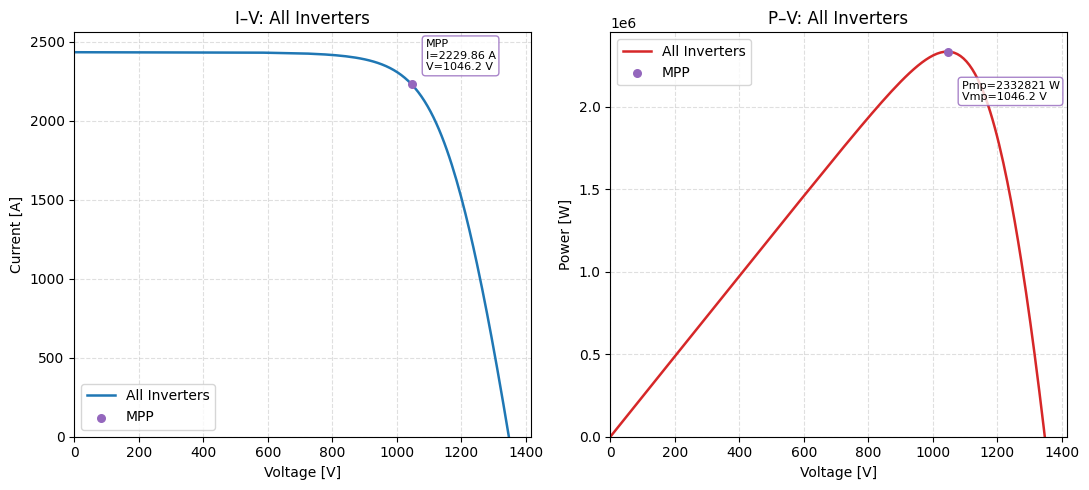


=== Mismatch Report for Inverters [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ===
module_MPPs_sum_degraded: 232956.1979202479
module_MPPs_sum_healthy: 235956.7732779795
string_MPPs_sum_degraded: 232861.91792783947
string_MPPs_sum_healthy: 235956.77344405037
system_MPP_degraded: 232642.33640636998
system_MPP_healthy: 235957.29920618678
total_module_loss: 3000.5753577315772
total_string_loss: 3094.855516210897
total_system_loss: 3314.9627998168
mismatch_modules_to_strings: 94.27999240843928
mismatch_strings_to_system: 219.5815214694885
mismatch_total: 313.8615138779278
degradation_only: 3001.101285938872
percent_loss: 1.4048994504383128
percent_degradation_to_loss: 90.53197478127738
percent_mismatch_to_loss: 9.468025218722612
percent_degradation: 1.2718832161731166
percent_mismatch_total: 0.13301623426519468
percent_mismatch_strs_to_sys: 0.09305985540952111
percent_mismatch_mods_to_strs: 0.03995637885567359
percent_mismatch_strs_norm: 1.1187811008367827
percent_mismatch_strs_norm_vs_loss: 85.297674

In [5]:
inverters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sys_all = create_combined_system(inverters)
plot_system_iv_pv(sys_all, title=f"Combined Inverters {inverters}")

report = loss_calculator(sys_i01, healthy_sys, num_strs_affected=28)
print(f"\n=== Mismatch Report for Inverters {inverters} ===")
for k, v in report.items():
    print(f"{k}: {v}")

## Create all inverters

In [ ]:
system = create_all_inverters(path="string_summary_edited.xlsx", sheet="Sheet2")
# system[1], system[2], ...

report = loss_calculator(sys_i01, healthy_sys, num_strs_affected=28)
print(f"\n=== Mismatch Report for Inverter {inv} ===")
for k, v in report.items():
    print(f"{k}: {v}")